In [4]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from collections import Counter
import os
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim

# Random Prototyping

In [13]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: TF.rotate(x, -90)), transforms.Lambda(lambda x: TF.hflip(x)), transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, download=False, transform=transform)
test_set = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=False, transform=transform)

# Convert dataset to DataLoader (load all at once)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

# Extract entire train and test data
train_data = torch.cat([data for data, _ in train_loader], dim=0)
train_labels = torch.cat([labels for _, labels in train_loader], dim=0)

test_data = torch.cat([data for data, _ in test_loader], dim=0)
test_labels = torch.cat([labels for _, labels in test_loader], dim=0)

# Flatten images from (N, 1, 28, 28) -> (N, 784)
train_data = train_data.view(train_data.shape[0], -1).to(device)  # (60000, 784)
test_data = test_data.view(test_data.shape[0], -1).to(device)  # (10000, 784)

train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

Using device: cpu


In [14]:
mapping_path = './data/EMNIST/raw/emnist-letters-mapping.txt'
mapping = pd.read_csv(mapping_path, delimiter=' ', header=None, index_col=0)
label_to_char = {index: chr(row[1]) for index, row in mapping.iterrows()}
train_labels_mapped = [label_to_char[label.item()] for label in train_labels]
test_labels_mapped = [label_to_char[label.item()] for label in test_labels]

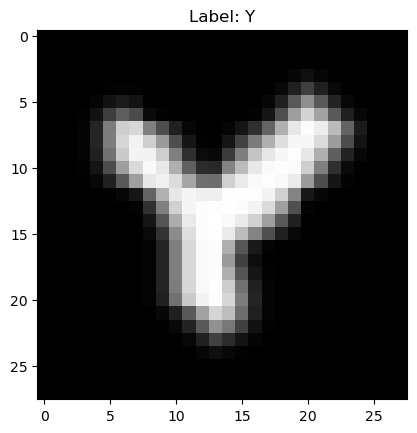

In [15]:
img, label = train_data[500], train_labels_mapped[500]  # Get first image & label
plt.imshow(img.view(28,28), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [16]:
num_subsets = np.array([75000, 50000, 10000, 5000, 1000])

In [17]:
def compute_accuracy(test_data, prototype_data, prototype_labels, k=1):
    # Compute full pairwise distance matrix in one go
    print("Computing full distance matrix...")
    distances = torch.cdist(test_data, prototype_data)  # Shape: (10000, 60000)

    # Get indices of k nearest neighbors
    k_indices = torch.topk(distances, k, largest=False).indices  # Shape: (10000, k)

    # Retrieve the k nearest labels
    k_labels = prototype_labels[k_indices]  # Shape: (10000, k)

    # Majority voting for prediction
    pred_labels = torch.mode(k_labels, dim=1).values  # Shape: (10000,)

    # Compute accuracy
    accuracy = (pred_labels == test_labels).float().mean().item()
    print(f'{k}-NN accuracy on full test set (no batching): {accuracy:.4f}')
    return accuracy

In [ ]:
accuracy_dict = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
        accuracy_list.append(accuracy)
    accuracy_dict[subset] = accuracy_list

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8536
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8547
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8534
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8529
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8530
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8538
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8536
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8528
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8542
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8551
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8538
Computing full distance matrix...
1-NN accu

In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.mean(), accuracy_df.std(ddof=1)

(100000    0.853282
 75000     0.845707
 50000     0.833377
 10000     0.766494
 5000      0.727639
 1000      0.599655
 dtype: float64,
 100000    0.000897
 75000     0.001687
 50000     0.002110
 10000     0.002243
 5000      0.003012
 1000      0.006118
 dtype: float64)

### Varying K

In [ ]:
full_accuracy_df_random = pd.DataFrame()

num_neighbors = np.arange(1,31,2)

for k in num_neighbors:
    accuracy_dict_random_per_neigbor = {}
    for subset in num_subsets:
        accuracy_list = []
        for _ in range(15):
            random_indicies = torch.randperm(train_data.shape[0])[:subset]
            prototype_train_data = train_data[random_indicies]
            prototype_train_labels = train_labels[random_indicies]
            accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
            accuracy_list.append(accuracy)
        accuracy_dict_random_per_neigbor[subset] = accuracy_list
    temp = pd.DataFrame(accuracy_dict_random_per_neigbor)
    temp['k'] = k
    full_accuracy_df_random = pd.concat([full_accuracy_df_random, temp], axis=0)

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8450
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8462
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8438
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8451
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8458
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8467
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8443
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8452
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8449
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8470
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8444
Computing full distance matrix...
1-NN accu

In [20]:
full_accuracy_df_random

,75000,50000,10000,5000,1000,k
0,0.845000,0.833317,0.772356,0.728654,0.610962,1
1,0.846154,0.830625,0.767644,0.728365,0.607933,1
2,0.843846,0.835337,0.761635,0.726058,0.600577,1
3,0.845096,0.832356,0.775288,0.728029,0.606971,1
4,0.845817,0.832981,0.761250,0.728654,0.595337,1
...,...,...,...,...,...,...
10,0.816490,0.796442,0.711058,0.656298,0.510625,29
11,0.815337,0.797644,0.706106,0.664663,0.516010,29
12,0.815529,0.799375,0.709327,0.654808,0.473798,29
13,0.813606,0.797404,0.709135,0.659423,0.482452,29


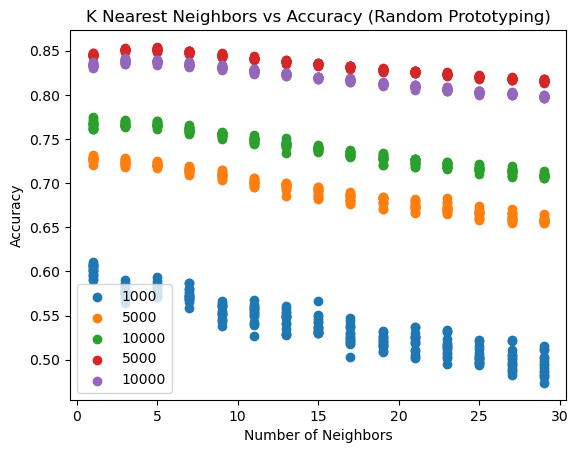

In [21]:
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[1000], label='1000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[5000], label='5000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[10000], label='10000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[75000], label='5000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[50000], label='10000')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (Random Prototyping)')
plt.legend()
plt.show()

# K Means

## K Means

### Base Functions

In [6]:
# Perform K-Means clustering

def optimized_kmeans(X, k, num_iters=100, tol=1e-4, batch_size=5000, device='cpu'):
    X = X.to(device, dtype=torch.float32)  # Ensure correct dtype
    N, D = X.shape

    # Initialize centroids randomly
    indices = torch.randperm(N)[:k]
    centroids = X[indices]

    for i in range(num_iters):
        cluster_assignments = torch.empty(N, dtype=torch.long, device=device)

        # Compute distances in batches to save memory
        for j in range(0, N, batch_size):
            batch = X[j:j+batch_size]
            distances = torch.cdist(batch, centroids)  # Compute distance for this batch
            cluster_assignments[j:j+batch_size] = torch.argmin(distances, dim=1)  # Assign cluster

        # Compute new centroids
        new_centroids = torch.zeros_like(centroids)
        counts = torch.zeros(k, device=device)

        for c in range(k):
            cluster_indices = (cluster_assignments == c).nonzero(as_tuple=True)[0]
            if cluster_indices.numel() > 0:
                new_centroids[c] = X[cluster_indices].mean(dim=0)
                counts[c] = cluster_indices.numel()
            else:
                # Assign the farthest point to avoid empty clusters
                farthest_point = X[torch.argmax(torch.cdist(X, centroids[c].unsqueeze(0)), dim=0)]
                new_centroids[c] = farthest_point

        # Check for convergence
        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break

        centroids = new_centroids

    return cluster_assignments, centroids




# Function to assign labels to centroids
def assign_labels(cluster_labels, y_true, k):
    """
    Assigns a label to each K-Means cluster using majority voting.
    
    Args:
    - cluster_labels (Tensor): Cluster assignments for each point
    - y_true (Tensor): True MNIST labels
    - k (int): Number of clusters

    Returns:
    - cluster_to_label (list): List where index `i` corresponds to cluster `i`'s assigned label
    """
    cluster_to_label = [-1] * k  # Initialize list with -1 for empty clusters

    for cluster in range(k):
        # Get all true labels for this cluster
        cluster_indices = (cluster_labels == cluster).nonzero(as_tuple=True)[0]
        true_labels = y_true[cluster_indices]

        # Find the most common label in this cluster
        if len(true_labels) > 0:
            most_common_label = Counter(true_labels.tolist()).most_common(1)[0][0]
            cluster_to_label[cluster] = most_common_label

    return cluster_to_label


### Centroids

In [9]:
for subset in num_subsets:
    if os.path.exists(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = optimized_kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        if os.path.exists('emnist_centroids') == False:
            os.mkdir('emnist_centroids')
        torch.save(centroids, f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth")

### Make Predictions

In [10]:
accuracy_dict_kmeans = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans[subset] = [accuracy]

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8486
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8454
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8332
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8140
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7510


In [11]:
accuracy_df_kmeans = pd.DataFrame(accuracy_dict_kmeans)
accuracy_df_kmeans

,75000,50000,10000,5000,1000
0,0.848606,0.845433,0.833221,0.81399,0.75101


### Varying size K

In [12]:
full_accuracy_df_kmeans = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans = pd.concat([full_accuracy_df_kmeans, temp], axis=0)
full_accuracy_df_kmeans['k'] = num_neighbors

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8486
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8454
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8332
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8140
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7510
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8577
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8526
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8297
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8112
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.7236
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8594
Computing full distance matrix...
5-NN accu

In [13]:
full_accuracy_df_kmeans

,75000,50000,10000,5000,1000,k
0,0.848606,0.845433,0.833221,0.813990,0.751010,1
0,0.857692,0.852644,0.829712,0.811154,0.723558,3
0,0.859423,0.855481,0.830240,0.811635,0.717163,5
0,0.858365,0.853942,0.824423,0.805769,0.705481,7
0,0.856250,0.849038,0.820433,0.798702,0.697260,9
0,0.853942,0.846779,0.816442,0.793221,0.687644,11
0,0.849760,0.843990,0.811683,0.789231,0.676442,13
0,0.846298,0.840817,0.806875,0.781779,0.665913,15
0,0.843894,0.838558,0.802981,0.776058,0.658558,17
0,0.840000,0.834567,0.797596,0.771827,0.653654,19


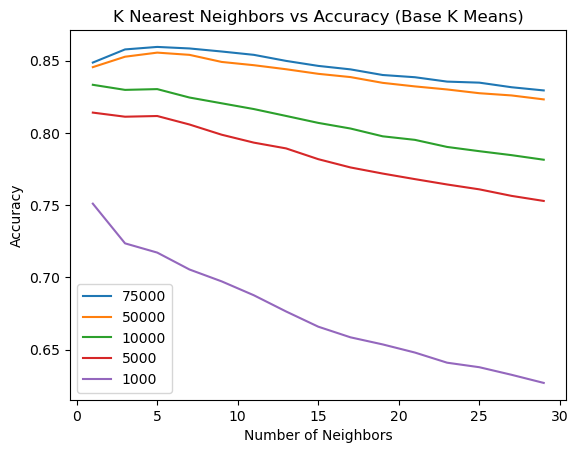

In [ ]:
for subset in num_subsets:
    plt.plot(full_accuracy_df_kmeans['k'], full_accuracy_df_kmeans[subset], label=f'{subset}')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (K Means++)')
plt.legend()
plt.show()

## K-Means++

### Base Fuctions

In [10]:


@torch.jit.script
def parallel_kmeans_plusplus(X: torch.Tensor, k: int) -> torch.Tensor:
    N, D = X.shape
    device = X.device
    centroids = torch.empty((k, D), device=device)

    # 1️⃣ Pick first centroid randomly
    first_idx = torch.randint(0, N, (1,))
    centroids[0] = X[first_idx.squeeze()]  # ✅ Fix indexing

    # 2️⃣ Track min distances
    min_distances = torch.full((N,), float('inf'), device=device)

    for i in range(1, k):
        if i % 100 == 0:
            print(f"Iter {i}")
        # Compute squared distances (ensuring correct shape)
        new_distances = torch.sum((X - centroids[i-1].unsqueeze(0)) ** 2, dim=1)  # ✅ Fix broadcasting

        # Update min distances
        min_distances = torch.minimum(min_distances, new_distances)

        # Sample next centroid
        probabilities = min_distances / min_distances.sum()
        next_idx = torch.multinomial(probabilities, 1)
        centroids[i] = X[next_idx.squeeze()]  # ✅ Fix indexing

    return centroids




def optimized_kmeans(X, k, num_iters=100, tol=1e-4, batch_size=10000, device='cpu'):
    X = X.to(device, dtype=torch.float32)  # Ensure correct dtype
    N, D = X.shape

    # Initialize centroids K-Means++
    centroids = parallel_kmeans_plusplus(X, k)

    for i in range(num_iters):
        cluster_assignments = torch.empty(N, dtype=torch.long, device=device)

        # Compute distances in batches to save memory
        for j in range(0, N, batch_size):
            batch = X[j:j+batch_size]
            distances = torch.cdist(batch, centroids)  # Compute distance for this batch
            cluster_assignments[j:j+batch_size] = torch.argmin(distances, dim=1)  # Assign cluster

        # Compute new centroids
        new_centroids = torch.zeros_like(centroids)
        counts = torch.zeros(k, device=device)

        for c in range(k):
            cluster_indices = (cluster_assignments == c).nonzero(as_tuple=True)[0]
            if cluster_indices.numel() > 0:
                new_centroids[c] = X[cluster_indices].mean(dim=0)
                counts[c] = cluster_indices.numel()
            else:
                # Assign the farthest point to avoid empty clusters
                farthest_point = X[torch.argmax(torch.cdist(X, centroids[c].unsqueeze(0)), dim=0)]
                new_centroids[c] = farthest_point

        # Check for convergence
        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break

        centroids = new_centroids

    return cluster_assignments, centroids


### Create Centroids

In [12]:
for subset in num_subsets:
    if os.path.exists(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = optimized_kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        torch.save(centroids, f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth")

### Make Predictions

In [13]:
accuracy_dict_kmeans_plus = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans_plus[subset] = [accuracy]

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8539
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8472
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8287
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8178
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7526


In [14]:
accuracy_df_kmeans_plus = pd.DataFrame(accuracy_dict_kmeans_plus)
accuracy_df_kmeans_plus

,75000,50000,10000,5000,1000
0,0.853942,0.847212,0.828702,0.817788,0.752596


### Varying K

In [19]:
full_accuracy_df_kmeans_plus = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans_plus = pd.concat([full_accuracy_df_kmeans_plus, temp], axis=0)
full_accuracy_df_kmeans_plus['k'] = num_neighbors

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8485
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8472
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8287
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8178
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7526
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8584
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8545
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8309
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8131
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.7220
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8599
Computing full distance matrix...
5-NN accu

In [20]:
full_accuracy_df_kmeans_plus

,75000,50000,10000,5000,1000,k
0,0.848462,0.847212,0.828702,0.817788,0.752596,1
0,0.858413,0.854471,0.830913,0.813125,0.722019,3
0,0.859904,0.854519,0.832452,0.812308,0.717212,5
0,0.859375,0.854279,0.827981,0.806250,0.705337,7
0,0.856346,0.850192,0.824183,0.800962,0.697308,9
0,0.853365,0.847885,0.820913,0.795625,0.686635,11
0,0.850240,0.843894,0.815000,0.787885,0.677837,13
0,0.847981,0.840529,0.810240,0.782596,0.667740,15
0,0.843942,0.837740,0.805337,0.778990,0.661971,17
0,0.840240,0.835433,0.799904,0.773990,0.653798,19


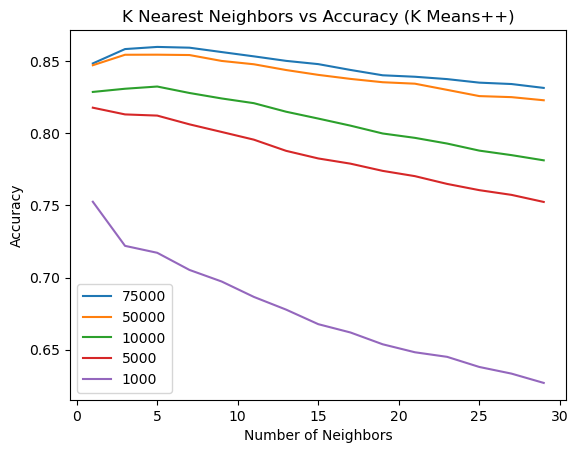

In [21]:
for subset in num_subsets:
    plt.plot(full_accuracy_df_kmeans_plus['k'], full_accuracy_df_kmeans_plus[subset], label=f'{subset}')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (K Means++)')
plt.legend()
plt.show()

# Learning Models

## Full Data

### Base Logit

In [23]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)  # Fully connected layer
        self.init_weights()
    
    def forward(self, x):
        return self.linear(x)  # No activation, since CrossEntropyLoss applies softmax
    
    def init_weights(self):
        nn.init.zeros_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

In [31]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=False, num_workers=4)

In [29]:
input_dim = 28 * 28
num_classes = 27
logit_model = LogisticRegression(input_dim, num_classes)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

In [68]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3
previous_loss = float('inf')  # Track the best loss
epochs_without_improvement = 0  # Counter for early stopping


for epoch in range(num_epochs):
    logit_model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

        # Forward pass
        outputs = logit_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer_sdg.zero_grad(set_to_none=True)
        loss.backward()
        optimizer_sdg.step()

        total_loss += loss.item()  # Accumulate total loss

    current_loss = total_loss / len(train_loader)  # Compute average loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

    # Check for early stopping
    if previous_loss - current_loss < tolerance:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
            break
    else:
        epochs_without_improvement = 0  # Reset counter if improvement occurs
    previous_loss = current_loss

Epoch [1/50], Loss: 1.1734
Epoch [2/50], Loss: 1.0344
Epoch [3/50], Loss: 1.0189
Epoch [4/50], Loss: 1.0091
Epoch [5/50], Loss: 1.0032
Epoch [6/50], Loss: 0.9984
Epoch [7/50], Loss: 0.9962
Epoch [8/50], Loss: 0.9918
Epoch [9/50], Loss: 0.9879
Epoch [10/50], Loss: 0.9861
Epoch [11/50], Loss: 0.9848
Epoch [12/50], Loss: 0.9851
Epoch [13/50], Loss: 0.9815
Epoch [14/50], Loss: 0.9806
Epoch [15/50], Loss: 0.9793
Epoch [16/50], Loss: 0.9783
Epoch [17/50], Loss: 0.9781
Epoch [18/50], Loss: 0.9778
Stopping early at epoch 18 (Loss improvement < 0.001 for 3 epochs)


In [69]:
logit_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = logit_model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Base Logit: {accuracy:.2f}%")

Test Accuracy Base Logit: 71.25%


### Lipschitz Logit

In [70]:
# Define Adam Optimizer
logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


# Early stopping parameters
tolerance = 1e-3  # Minimum change in loss to continue training
patience = 3  # Number of epochs to wait for improvement
previous_loss = float('inf')
epochs_without_improvement = 0  # Counter for early stopping

# Training loop with early stopping
num_epochs = 50  # Maximum epochs
for epoch in range(num_epochs):
    logit_model_lipschitz.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28 * 28)  # Flatten images

        outputs = logit_model_lipschitz(images)
        loss = criterion(outputs, labels)

        logit_model_lipschitz.zero_grad()
        loss.backward()

        L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
        adaptive_lr = min(0.1, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

        # Update optimizer's learning rate
        for param_group in optimizer_sdg.param_groups:
            param_group['lr'] = adaptive_lr

        optimizer_sdg.step()

        total_loss += loss.item()

    current_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

    # Check for early stopping
    if previous_loss - current_loss < tolerance:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
            break
    else:
        epochs_without_improvement = 0  # Reset counter if improvement occurs
    previous_loss = current_loss


Epoch [1/50], Loss: 1.6129
Epoch [2/50], Loss: 1.5576
Epoch [3/50], Loss: 1.5813
Epoch [4/50], Loss: 1.5550
Epoch [5/50], Loss: 1.5188
Epoch [6/50], Loss: 1.5362
Epoch [7/50], Loss: 1.5241
Epoch [8/50], Loss: 1.5394
Epoch [9/50], Loss: 1.5186
Epoch [10/50], Loss: 1.5239
Epoch [11/50], Loss: 1.5152
Epoch [12/50], Loss: 1.5130
Epoch [13/50], Loss: 1.5249
Epoch [14/50], Loss: 1.5295
Epoch [15/50], Loss: 1.5067
Epoch [16/50], Loss: 1.4989
Epoch [17/50], Loss: 1.5026
Epoch [18/50], Loss: 1.5074
Epoch [19/50], Loss: 1.5150
Stopping early at epoch 19 (Loss improvement < 0.001 for 3 epochs)


In [71]:
logit_model_lipschitz.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28*28)
        
        outputs = logit_model_lipschitz(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Newtonian Logit: {accuracy:.2f}%")

Test Accuracy Newtonian Logit: 61.73%


### Neural Network SGD

In [24]:
class EMNIST_CNN(nn.Module):
    def __init__(self, num_classes):
        super(EMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, num_classes)  # Adjust output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)  # Dynamically flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [73]:
cnn_model = EMNIST_CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

In [74]:
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

In [75]:
train_loader_cnn = DataLoader(
    train_set, batch_size=256, shuffle=True, 
    num_workers=8, pin_memory=True
)
val_loader_cnn = DataLoader(
    val_set, batch_size=256, shuffle=False, 
    num_workers=8, pin_memory=True
)
test_loader_cnn = DataLoader(
    test_set, batch_size=256, shuffle=False, 
    num_workers=8, pin_memory=True
)

In [76]:
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0


    for images, labels in train_loader_cnn:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)


        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer_sdg.zero_grad(set_to_none=True)
        loss.backward()
        optimizer_sdg.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader_cnn)

    # Validation loop
    cnn_model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)

            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()


    val_loss /= len(val_loader_cnn)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
            break

Epoch [1/50], Train Loss: 0.9479 Val Loss: 0.4327
Epoch [2/50], Train Loss: 0.3451 Val Loss: 0.3116
Epoch [3/50], Train Loss: 0.2644 Val Loss: 0.2814
Epoch [4/50], Train Loss: 0.2261 Val Loss: 0.2284
Epoch [5/50], Train Loss: 0.1990 Val Loss: 0.2249
Epoch [6/50], Train Loss: 0.1804 Val Loss: 0.2195
Epoch [7/50], Train Loss: 0.1647 Val Loss: 0.2126
Epoch [8/50], Train Loss: 0.1523 Val Loss: 0.2042
Epoch [9/50], Train Loss: 0.1407 Val Loss: 0.2111
Epoch [10/50], Train Loss: 0.1318 Val Loss: 0.2052
Epoch [11/50], Train Loss: 0.1206 Val Loss: 0.2088
Epoch [12/50], Train Loss: 0.1148 Val Loss: 0.2090
Epoch [13/50], Train Loss: 0.1048 Val Loss: 0.2123
Stopping early at epoch 13 (No improvement in 5 epochs)


In [77]:
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 92.66%


### Neural Network Lipschitz

In [78]:
cnn_model_lipschitz = EMNIST_CNN(num_classes).to(device)
optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    cnn_model_lipschitz.train()
    total_loss = 0
    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model_lipschitz(images)
        loss = criterion(outputs, labels)

    
        # Backward pass
        optimizer_sdg.zero_grad(set_to_none=True)
        loss.backward()

        L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
        adaptive_lr = min(0.1, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

        # Update optimizer's learning rate
        for param_group in optimizer_sdg.param_groups:
            param_group['lr'] = adaptive_lr

        optimizer_sdg.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader_cnn)

    # Validation loop
    cnn_model_lipschitz.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)

            outputs = cnn_model_lipschitz(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader_cnn)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
            break

Epoch [1/50], Train Loss: 0.8132 Val Loss: 0.3126
Epoch [2/50], Train Loss: 0.2581 Val Loss: 0.2363
Epoch [3/50], Train Loss: 0.2081 Val Loss: 0.2281
Epoch [4/50], Train Loss: 0.1767 Val Loss: 0.2166
Epoch [5/50], Train Loss: 0.1541 Val Loss: 0.2209
Epoch [6/50], Train Loss: 0.1391 Val Loss: 0.2208
Epoch [7/50], Train Loss: 0.1261 Val Loss: 0.2133
Epoch [8/50], Train Loss: 0.1139 Val Loss: 0.2247
Epoch [9/50], Train Loss: 0.1098 Val Loss: 0.2379
Epoch [10/50], Train Loss: 0.1016 Val Loss: 0.2385
Epoch [11/50], Train Loss: 0.0947 Val Loss: 0.2322
Epoch [12/50], Train Loss: 0.0886 Val Loss: 0.2481
Stopping early at epoch 12 (No improvement in 5 epochs)


In [80]:
cnn_model_lipschitz.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn_model_lipschitz(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Newtonian Logit: {accuracy:.2f}%")

Test Accuracy Newtonian Logit: 92.91%


## Random Prototypes

### Base Logit

In [32]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

logit_accuracy = {}

for subset_size in num_subsets:
    accuracy_list = []

    for _ in range(30):
        logit_model = LogisticRegression(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

        print(f"Training with subset size: {subset_size}")
        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = Subset(train_set, subset_indices)
        train_loader = DataLoader(subset, batch_size=128, shuffle=True)

        previous_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            logit_model.train()
            total_loss = 0

            for images, labels in train_loader:
                images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

                # Forward pass
                outputs = logit_model(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()
                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

            # Check for early stopping
            if previous_loss - current_loss < tolerance:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                    break
            else:
                epochs_without_improvement = 0  # Reset counter if improvement occurs
            previous_loss = current_loss

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        logit_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28*28)
                outputs = logit_model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy Base Logit: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy[subset_size] = accuracy_list

Training with subset size: 75000
Epoch [1/100], Loss: 1.1633
Epoch [2/100], Loss: 1.0499


KeyboardInterrupt: 

In [ ]:
logit_df = pd.DataFrame(logit_accuracy)
logit_df.mean(), logit_df.std()

(75000    51.869071
 50000    51.875481
 10000    51.880128
 5000     51.853846
 1000     51.879968
 dtype: float64,
 75000    0.058252
 50000    0.056129
 10000    0.048109
 5000     0.058727
 1000     0.062283
 dtype: float64)

### Lipschitz Logit

In [ ]:
num_epochs = 100
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3


logit_accuracy_lipschitz = {}

for subset_size in num_subsets:
    accuracy_list = []
    print(f"Training with subset size: {subset_size}")

    for _ in range(30):
        logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = Subset(train_set, subset_indices)
        train_loader = DataLoader(subset, batch_size=128, shuffle=True)

        previous_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            logit_model_lipschitz.train()
            total_loss = 0

            for images, labels in train_loader:
                images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

                # Forward pass
                outputs = logit_model_lipschitz(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()

                L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
                adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

                # Update optimizer's learning rate
                for param_group in optimizer_sdg.param_groups:
                    param_group['lr'] = adaptive_lr
                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

            # Check for early stopping
            if previous_loss - current_loss < tolerance:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                    break
            else:
                epochs_without_improvement = 0  # Reset counter if improvement occurs
            previous_loss = current_loss

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        logit_model_lipschitz.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(-1, 28*28)
                outputs = logit_model_lipschitz(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy Logit Lipschitz: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy_lipschitz[subset_size] = accuracy_list

Training with subset size: 75000
Epoch [1/100], Loss: 3.1913
Epoch [2/100], Loss: 2.5346
Epoch [3/100], Loss: 1.8812
Epoch [4/100], Loss: 1.4624
Epoch [5/100], Loss: 1.2147
Epoch [6/100], Loss: 1.0494
Epoch [7/100], Loss: 0.9298
Epoch [8/100], Loss: 0.8361
Epoch [9/100], Loss: 0.7509
Epoch [10/100], Loss: 0.6824
Epoch [11/100], Loss: 0.6215
Epoch [12/100], Loss: 0.5703
Epoch [13/100], Loss: 0.5277
Epoch [14/100], Loss: 0.4917
Epoch [15/100], Loss: 0.4598
Epoch [16/100], Loss: 0.4311
Epoch [17/100], Loss: 0.4057
Epoch [18/100], Loss: 0.3873
Epoch [19/100], Loss: 0.3657
Epoch [20/100], Loss: 0.3469
Epoch [21/100], Loss: 0.3312
Epoch [22/100], Loss: 0.3175
Epoch [23/100], Loss: 0.3032
Epoch [24/100], Loss: 0.2908
Epoch [25/100], Loss: 0.2784
Epoch [26/100], Loss: 0.2697
Epoch [27/100], Loss: 0.2587
Epoch [28/100], Loss: 0.2495
Epoch [29/100], Loss: 0.2419
Epoch [30/100], Loss: 0.2333
Epoch [31/100], Loss: 0.2263
Epoch [32/100], Loss: 0.2200
Epoch [33/100], Loss: 0.2123
Epoch [34/100], Los

In [ ]:
logit_accuracy_lipschitz_df = pd.DataFrame(logit_accuracy_lipschitz)
logit_accuracy_lipschitz_df.mean(), logit_accuracy_lipschitz_df.std()

(75000    51.780449
 50000    51.764904
 10000    51.779808
 5000     51.775962
 1000     51.780288
 dtype: float64,
 75000    0.047666
 50000    0.042748
 10000    0.026556
 5000     0.038701
 1000     0.038278
 dtype: float64)

### Neural Network

In [ ]:
num_epochs = 75
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3

logit_accuracy_cnn = {}

for subset_size in num_subsets:
    accuracy_list = []
    print(f"Training with subset size: {subset_size}")

    for _ in range(30):
        cnn_model = EMNIST_CNN(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


        def init_weights(m):
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                    m.bias.data.fill_(0.01)
        cnn_model.apply(init_weights)

        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = Subset(train_set, subset_indices)
        train_loader = DataLoader(subset, batch_size=128, shuffle=True)

        best_val_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            cnn_model.train()
            total_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = cnn_model(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()

                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

            # Validation loop
            cnn_model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for images, labels in val_loader_cnn:
                    images, labels = images.to(device), labels.to(device)

                    outputs = cnn_model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader_cnn)

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Val Loss: {val_loss:.4f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                    break

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        cnn_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn_model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy Base CNN: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy_cnn[subset_size] = accuracy_list

Training with subset size: 75000
Epoch [1/75], Loss: 3.3893
Epoch [1/75], Val Loss: 3.2876
Epoch [2/75], Loss: 3.2100
Epoch [2/75], Val Loss: 3.1802
Epoch [3/75], Loss: 3.0715
Epoch [3/75], Val Loss: 3.0702
Epoch [4/75], Loss: 2.9060
Epoch [4/75], Val Loss: 2.9066
Epoch [5/75], Loss: 2.6687
Epoch [5/75], Val Loss: 2.6574
Epoch [6/75], Loss: 2.3342
Epoch [6/75], Val Loss: 2.3375
Epoch [7/75], Loss: 1.9452
Epoch [7/75], Val Loss: 2.0189
Epoch [8/75], Loss: 1.6195
Epoch [8/75], Val Loss: 1.8608
Epoch [9/75], Loss: 1.3972
Epoch [9/75], Val Loss: 1.7338
Epoch [10/75], Loss: 1.2567
Epoch [10/75], Val Loss: 1.7310
Epoch [11/75], Loss: 1.1465
Epoch [11/75], Val Loss: 1.7162
Epoch [12/75], Loss: 1.0624
Epoch [12/75], Val Loss: 1.7663
Epoch [13/75], Loss: 0.9794
Epoch [13/75], Val Loss: 1.6637
Epoch [14/75], Loss: 0.8889
Epoch [14/75], Val Loss: 1.5926
Epoch [15/75], Loss: 0.7530
Epoch [15/75], Val Loss: 1.5128
Epoch [16/75], Loss: 0.6511
Epoch [16/75], Val Loss: 1.5327
Epoch [17/75], Loss: 0.54

In [ ]:
logit_accuracy_cnn_df = pd.DataFrame(logit_accuracy_cnn)
logit_accuracy_cnn_df.mean(), logit_accuracy_cnn_df.std()

(75000    58.691026
 50000    58.113462
 10000    58.961058
 5000     58.189744
 1000     58.517949
 dtype: float64,
 75000    3.065160
 50000    3.490867
 10000    3.076392
 5000     3.414451
 1000     3.270635
 dtype: float64)

### Neural Network Lipschitz

In [ ]:
num_epochs = 75
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3

logit_accuracy_cnn_lipschitz = {}

for subset_size in num_subsets:
    accuracy_list = []
    print(f"Training with subset size: {subset_size}")

    for _ in range(30):
        cnn_model_lipschitz = EMNIST_CNN(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


        def init_weights(m):
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                    m.bias.data.fill_(0.01)
        cnn_model_lipschitz.apply(init_weights)

        subset_indices = torch.randperm(train_data.shape[0])[:subset_size]
        subset = Subset(train_set, subset_indices)
        train_loader = DataLoader(subset, batch_size=128, shuffle=True)

        best_val_loss = float('inf')  # Track the best loss
        epochs_without_improvement = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            cnn_model_lipschitz.train()
            total_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = cnn_model_lipschitz(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer_sdg.zero_grad(set_to_none=True)
                loss.backward()

                L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
                adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

                # Update optimizer's learning rate
                for param_group in optimizer_sdg.param_groups:
                    param_group['lr'] = adaptive_lr

                optimizer_sdg.step()

                total_loss += loss.item()  # Accumulate total loss

            current_loss = total_loss / len(train_loader)  # Compute average loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

           # Validation loop
            cnn_model_lipschitz.eval()
            val_loss = 0
            
            with torch.no_grad():
                for images, labels in val_loader_cnn:
                    images, labels = images.to(device), labels.to(device)

                    outputs = cnn_model_lipschitz(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader_cnn)

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Val Loss: {val_loss:.4f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                    break

        print(f"Subset {subset_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        cnn_model_lipschitz.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn_model_lipschitz(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy CNN Lipschitz: {accuracy:.2f}%")

        accuracy_list.append(accuracy)

    logit_accuracy_cnn_lipschitz[subset_size] = accuracy_list

Training with subset size: 75000
Epoch [1/75], Loss: 3.3661
Epoch [1/75], Val Loss: 3.2430
Epoch [2/75], Loss: 3.1305
Epoch [2/75], Val Loss: 3.1189
Epoch [3/75], Loss: 2.9506
Epoch [3/75], Val Loss: 2.8956
Epoch [4/75], Loss: 2.6276
Epoch [4/75], Val Loss: 2.5203
Epoch [5/75], Loss: 2.0891
Epoch [5/75], Val Loss: 2.0087
Epoch [6/75], Loss: 1.5938
Epoch [6/75], Val Loss: 1.8960
Epoch [7/75], Loss: 1.4597
Epoch [7/75], Val Loss: 1.8930
Epoch [8/75], Loss: 1.3161
Epoch [8/75], Val Loss: 1.8796
Epoch [9/75], Loss: 1.2388
Epoch [9/75], Val Loss: 1.8387
Epoch [10/75], Loss: 0.9902
Epoch [10/75], Val Loss: 1.5769
Epoch [11/75], Loss: 0.8399
Epoch [11/75], Val Loss: 1.6159
Epoch [12/75], Loss: 0.7813
Epoch [12/75], Val Loss: 1.4787
Epoch [13/75], Loss: 0.6041
Epoch [13/75], Val Loss: 1.4373
Epoch [14/75], Loss: 0.4957
Epoch [14/75], Val Loss: 1.4362
Epoch [15/75], Loss: 0.4293
Epoch [15/75], Val Loss: 1.5391
Epoch [16/75], Loss: 0.3214
Epoch [16/75], Val Loss: 1.5584
Epoch [17/75], Loss: 0.26

In [ ]:
logit_accuracy_cnn_lipschitz_df = pd.DataFrame(logit_accuracy_cnn_lipschitz)
logit_accuracy_cnn_lipschitz_df.mean(), logit_accuracy_cnn_lipschitz_df.std()

(75000    59.066506
 50000    57.689103
 10000    58.432372
 5000     58.784295
 1000     58.456250
 dtype: float64,
 75000    5.838888
 50000    7.303048
 10000    5.382737
 5000     6.069793
 1000     5.998636
 dtype: float64)

## K Means

In [143]:
class KMeans(Dataset):
    def __init__(self, centroids, labels):
        """
        centroids: torch.Tensor or numpy array of shape (N, D) where N is the number of samples, D is the feature size.
        labels: torch.Tensor or numpy array of shape (N,) containing class labels.
        """
        self.centroids = centroids.clone().detach().float()
        self.labels = labels.clone().detach().long()

    def __len__(self):
        return len(self.centroids)

    def __getitem__(self, idx):
        return self.centroids[idx], self.labels[idx]

### Base Logit

In [144]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

base_logit_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    logit_model = LogisticRegression(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

    previous_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        logit_model.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

            # Forward pass
            outputs = logit_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Check for early stopping
        if previous_loss - current_loss < tolerance:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                break
        else:
            epochs_without_improvement = 0  # Reset counter if improvement occurs
        previous_loss = current_loss

    logit_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = logit_model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Base Logit K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    base_logit_kmeans[subset] = accuracy_list

Epoch [1/100], Loss: 175.4606
Epoch [2/100], Loss: 158.9786
Epoch [3/100], Loss: 156.4019
Epoch [4/100], Loss: 155.2115
Epoch [5/100], Loss: 154.2610
Epoch [6/100], Loss: 153.4348
Epoch [7/100], Loss: 153.0185
Epoch [8/100], Loss: 152.6335
Epoch [9/100], Loss: 152.0356
Epoch [10/100], Loss: 151.7344
Epoch [11/100], Loss: 151.5714
Epoch [12/100], Loss: 150.6712
Epoch [13/100], Loss: 151.0839
Epoch [14/100], Loss: 150.6006
Epoch [15/100], Loss: 150.1626
Epoch [16/100], Loss: 149.9008
Epoch [17/100], Loss: 150.2816
Epoch [18/100], Loss: 149.7011
Epoch [19/100], Loss: 149.4352
Epoch [20/100], Loss: 149.3675
Epoch [21/100], Loss: 149.4079
Epoch [22/100], Loss: 149.1935
Epoch [23/100], Loss: 148.8121
Epoch [24/100], Loss: 148.7812
Epoch [25/100], Loss: 148.8039
Epoch [26/100], Loss: 148.6196
Epoch [27/100], Loss: 148.8564
Epoch [28/100], Loss: 148.4779
Epoch [29/100], Loss: 148.5490
Epoch [30/100], Loss: 148.5787
Epoch [31/100], Loss: 148.5956
Stopping early at epoch 31 (Loss improvement < 0

In [145]:
base_logit_kmeans_df = pd.DataFrame(base_logit_kmeans)
base_logit_kmeans_df

,75000,50000,10000,5000,1000
0,69.461538,67.889423,65.197115,64.961538,63.0625


### Lipschitz Logit

In [146]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

lipschitz_logit_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

    previous_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        logit_model_lipschitz.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

            # Forward pass
            outputs = logit_model_lipschitz(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()

            L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
            adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

            # Update optimizer's learning rate
            for param_group in optimizer_sdg.param_groups:
                param_group['lr'] = adaptive_lr


            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Check for early stopping
        if previous_loss - current_loss < tolerance:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                break
        else:
            epochs_without_improvement = 0  # Reset counter if improvement occurs
        previous_loss = current_loss

    logit_model_lipschitz.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = logit_model_lipschitz(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Lipschitz Logit K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    lipschitz_logit_kmeans[subset] = accuracy_list

Epoch [1/100], Loss: 174.7797
Epoch [2/100], Loss: 158.9948
Epoch [3/100], Loss: 156.4363
Epoch [4/100], Loss: 155.3280
Epoch [5/100], Loss: 154.2844
Epoch [6/100], Loss: 153.4449
Epoch [7/100], Loss: 152.8901
Epoch [8/100], Loss: 152.3302
Epoch [9/100], Loss: 152.0780
Epoch [10/100], Loss: 151.5151
Epoch [11/100], Loss: 151.4044
Epoch [12/100], Loss: 151.1122
Epoch [13/100], Loss: 150.9331
Epoch [14/100], Loss: 150.2972
Epoch [15/100], Loss: 150.3928
Epoch [16/100], Loss: 150.3375
Epoch [17/100], Loss: 150.0230
Epoch [18/100], Loss: 149.4260
Epoch [19/100], Loss: 149.8679
Epoch [20/100], Loss: 149.2008
Epoch [21/100], Loss: 149.7504
Epoch [22/100], Loss: 149.3839
Epoch [23/100], Loss: 149.1636
Epoch [24/100], Loss: 149.1011
Epoch [25/100], Loss: 149.1429
Epoch [26/100], Loss: 148.6327
Epoch [27/100], Loss: 148.9050
Epoch [28/100], Loss: 148.3092
Epoch [29/100], Loss: 148.3335
Epoch [30/100], Loss: 148.4233
Epoch [31/100], Loss: 148.7612
Stopping early at epoch 31 (Loss improvement < 0

In [147]:
lipschitz_logit_kmeans_df = pd.DataFrame(lipschitz_logit_kmeans)
lipschitz_logit_kmeans_df

,75000,50000,10000,5000,1000
0,69.408654,68.548077,65.918269,64.716346,63.1875


### Neural Network

In [148]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

cnn_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    cnn_model = EMNIST_CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)


    def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                m.bias.data.fill_(0.01)
    cnn_model.apply(init_weights)

    best_val_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        cnn_model.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Validation loop
        cnn_model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader_cnn:
                images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

                outputs = cnn_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader_cnn)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                break


    cnn_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy CNN K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    cnn_kmeans[subset] = accuracy_list

Epoch [1/50], Loss: 94.5194
Epoch [1/50], Val Loss: 0.2846
Epoch [2/50], Loss: 44.7997
Epoch [2/50], Val Loss: 0.2217
Epoch [3/50], Loss: 36.9589
Epoch [3/50], Val Loss: 0.1807
Epoch [4/50], Loss: 32.0297
Epoch [4/50], Val Loss: 0.1678
Epoch [5/50], Loss: 28.7951
Epoch [5/50], Val Loss: 0.1569
Epoch [6/50], Loss: 25.9148
Epoch [6/50], Val Loss: 0.1677
Epoch [7/50], Loss: 23.0563
Epoch [7/50], Val Loss: 0.1464
Epoch [8/50], Loss: 21.1001
Epoch [8/50], Val Loss: 0.1412
Epoch [9/50], Loss: 18.7614
Epoch [9/50], Val Loss: 0.1422
Epoch [10/50], Loss: 17.3641
Epoch [10/50], Val Loss: 0.1389
Epoch [11/50], Loss: 15.4320
Epoch [11/50], Val Loss: 0.1325
Epoch [12/50], Loss: 14.2311
Epoch [12/50], Val Loss: 0.1361
Epoch [13/50], Loss: 13.0377
Epoch [13/50], Val Loss: 0.1347
Epoch [14/50], Loss: 12.0162
Epoch [14/50], Val Loss: 0.1372
Stopping early at epoch 14 (No improvement in 3 epochs)
Test Accuracy CNN K Means: 92.61%
Epoch [1/50], Loss: 78.8384
Epoch [1/50], Val Loss: 0.3505
Epoch [2/50], L

In [149]:
cnn_kmeans_df = pd.DataFrame(cnn_kmeans)
cnn_kmeans_df

,75000,50000,10000,5000,1000
0,92.610577,92.009615,86.120192,83.129808,66.225962


### Neural Network Lipschitz

In [150]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

cnn_lipschitz_kmeans = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    cnn_model_lipschitz = EMNIST_CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


    def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                m.bias.data.fill_(0.01)
    cnn_model_lipschitz.apply(init_weights)

    best_val_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        cnn_model_lipschitz.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model_lipschitz(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()

            L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
            adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

            # Update optimizer's learning rate
            for param_group in optimizer_sdg.param_groups:
                param_group['lr'] = adaptive_lr
                
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Validation loop
        cnn_model_lipschitz.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader_cnn:
                images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

                outputs = cnn_model_lipschitz(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader_cnn)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                break


    cnn_model_lipschitz.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)
            outputs = cnn_model_lipschitz(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Lipschitz CNN K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    cnn_lipschitz_kmeans[subset] = accuracy_list

Epoch [1/50], Loss: 99.0845
Epoch [1/50], Val Loss: 0.2954
Epoch [2/50], Loss: 45.3697
Epoch [2/50], Val Loss: 0.2222
Epoch [3/50], Loss: 37.5560
Epoch [3/50], Val Loss: 0.1874
Epoch [4/50], Loss: 32.9338
Epoch [4/50], Val Loss: 0.1738
Epoch [5/50], Loss: 29.2415
Epoch [5/50], Val Loss: 0.1615
Epoch [6/50], Loss: 26.3568
Epoch [6/50], Val Loss: 0.1512
Epoch [7/50], Loss: 24.1001
Epoch [7/50], Val Loss: 0.1534
Epoch [8/50], Loss: 21.8716
Epoch [8/50], Val Loss: 0.1401
Epoch [9/50], Loss: 20.1402
Epoch [9/50], Val Loss: 0.1351
Epoch [10/50], Loss: 18.3980
Epoch [10/50], Val Loss: 0.1399
Epoch [11/50], Loss: 16.6092
Epoch [11/50], Val Loss: 0.1396
Epoch [12/50], Loss: 15.2523
Epoch [12/50], Val Loss: 0.1343
Epoch [13/50], Loss: 13.6351
Epoch [13/50], Val Loss: 0.1301
Epoch [14/50], Loss: 12.9812
Epoch [14/50], Val Loss: 0.1333
Epoch [15/50], Loss: 11.8987
Epoch [15/50], Val Loss: 0.1358
Epoch [16/50], Loss: 10.9193
Epoch [16/50], Val Loss: 0.1405
Stopping early at epoch 16 (No improvement

In [151]:
cnn_lipschitz_kmeans_df = pd.DataFrame(cnn_lipschitz_kmeans)
cnn_lipschitz_kmeans_df

,75000,50000,10000,5000,1000
0,92.480769,91.230769,86.192308,82.302885,65.163462


## K Means++

### Base Logit

In [152]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

base_logit_kmeans_plus = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    logit_model = LogisticRegression(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(logit_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

    previous_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        logit_model.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

            # Forward pass
            outputs = logit_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Check for early stopping
        if previous_loss - current_loss < tolerance:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                break
        else:
            epochs_without_improvement = 0  # Reset counter if improvement occurs
        previous_loss = current_loss

    logit_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = logit_model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Base Logit K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    base_logit_kmeans_plus[subset] = accuracy_list

Epoch [1/100], Loss: 174.9038
Epoch [2/100], Loss: 158.5837
Epoch [3/100], Loss: 156.6188
Epoch [4/100], Loss: 155.2408
Epoch [5/100], Loss: 154.1766
Epoch [6/100], Loss: 153.3897
Epoch [7/100], Loss: 152.9343
Epoch [8/100], Loss: 152.2684
Epoch [9/100], Loss: 151.7720
Epoch [10/100], Loss: 151.3398
Epoch [11/100], Loss: 151.4978
Epoch [12/100], Loss: 150.7178
Epoch [13/100], Loss: 150.9036
Epoch [14/100], Loss: 150.8395
Epoch [15/100], Loss: 150.1416
Epoch [16/100], Loss: 149.7245
Epoch [17/100], Loss: 150.3522
Epoch [18/100], Loss: 149.7974
Epoch [19/100], Loss: 149.3703
Epoch [20/100], Loss: 149.4271
Epoch [21/100], Loss: 149.0711
Epoch [22/100], Loss: 148.9810
Epoch [23/100], Loss: 148.9032
Epoch [24/100], Loss: 148.5919
Epoch [25/100], Loss: 148.9894
Epoch [26/100], Loss: 148.5118
Epoch [27/100], Loss: 148.0841
Epoch [28/100], Loss: 148.3945
Epoch [29/100], Loss: 148.4000
Epoch [30/100], Loss: 148.2652
Epoch [31/100], Loss: 148.2148
Epoch [32/100], Loss: 148.0385
Epoch [33/100], L

In [153]:
base_logit_kmeans_plus_df = pd.DataFrame(base_logit_kmeans_plus)
base_logit_kmeans_plus_df

,75000,50000,10000,5000,1000
0,69.206731,68.427885,64.028846,63.975962,62.682692


### Lipschitz Logit

In [154]:
num_epochs = 100
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

lipschitz_logit_kmeans_plus = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    logit_model_lipschitz = LogisticRegression(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(logit_model_lipschitz.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

    previous_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        logit_model_lipschitz.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

            # Forward pass
            outputs = logit_model_lipschitz(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()

            L = max(param.grad.abs().max().item() for param in logit_model_lipschitz.parameters() if param.grad is not None)
            adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

            # Update optimizer's learning rate
            for param_group in optimizer_sdg.param_groups:
                param_group['lr'] = adaptive_lr


            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Check for early stopping
        if previous_loss - current_loss < tolerance:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
                break
        else:
            epochs_without_improvement = 0  # Reset counter if improvement occurs
        previous_loss = current_loss

    logit_model_lipschitz.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = logit_model_lipschitz(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Lipschitz Logit K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    lipschitz_logit_kmeans_plus[subset] = accuracy_list

Epoch [1/100], Loss: 174.9405
Epoch [2/100], Loss: 159.1250
Epoch [3/100], Loss: 156.4808
Epoch [4/100], Loss: 154.8477
Epoch [5/100], Loss: 153.9503
Epoch [6/100], Loss: 153.3894
Epoch [7/100], Loss: 152.9291
Epoch [8/100], Loss: 152.2461
Epoch [9/100], Loss: 151.7452
Epoch [10/100], Loss: 151.9274
Epoch [11/100], Loss: 151.0914
Epoch [12/100], Loss: 151.0563
Epoch [13/100], Loss: 150.9092
Epoch [14/100], Loss: 150.3412
Epoch [15/100], Loss: 150.1272
Epoch [16/100], Loss: 150.0380
Epoch [17/100], Loss: 149.6670
Epoch [18/100], Loss: 149.4642
Epoch [19/100], Loss: 149.5227
Epoch [20/100], Loss: 149.3764
Epoch [21/100], Loss: 149.3691
Epoch [22/100], Loss: 149.1877
Epoch [23/100], Loss: 148.8774
Epoch [24/100], Loss: 148.4891
Epoch [25/100], Loss: 148.5754
Epoch [26/100], Loss: 148.4985
Epoch [27/100], Loss: 148.2859
Epoch [28/100], Loss: 148.5809
Epoch [29/100], Loss: 148.2279
Epoch [30/100], Loss: 147.9092
Epoch [31/100], Loss: 148.0905
Epoch [32/100], Loss: 147.9455
Epoch [33/100], L

In [155]:
lipschitz_logit_kmeans_plus_df = pd.DataFrame(lipschitz_logit_kmeans_plus)
lipschitz_logit_kmeans_plus_df

,75000,50000,10000,5000,1000
0,68.879808,68.663462,66.216346,65.293269,62.701923


### Neural Network

In [156]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

cnn_kmeans_plus = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    cnn_model = EMNIST_CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(cnn_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)


    def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                m.bias.data.fill_(0.01)
    cnn_model.apply(init_weights)

    best_val_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        cnn_model.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Validation loop
        cnn_model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader_cnn:
                images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

                outputs = cnn_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader_cnn)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                break


    cnn_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy CNN K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    cnn_kmeans_plus[subset] = accuracy_list

Epoch [1/50], Loss: 98.8394
Epoch [1/50], Val Loss: 0.3164
Epoch [2/50], Loss: 45.7895
Epoch [2/50], Val Loss: 0.2282
Epoch [3/50], Loss: 37.1084
Epoch [3/50], Val Loss: 0.2005
Epoch [4/50], Loss: 32.3625
Epoch [4/50], Val Loss: 0.1843
Epoch [5/50], Loss: 29.0090
Epoch [5/50], Val Loss: 0.1614
Epoch [6/50], Loss: 25.9818
Epoch [6/50], Val Loss: 0.1706
Epoch [7/50], Loss: 23.6929
Epoch [7/50], Val Loss: 0.1518
Epoch [8/50], Loss: 21.1231
Epoch [8/50], Val Loss: 0.1482
Epoch [9/50], Loss: 19.3193
Epoch [9/50], Val Loss: 0.1493
Epoch [10/50], Loss: 17.2926
Epoch [10/50], Val Loss: 0.1447
Epoch [11/50], Loss: 16.0399
Epoch [11/50], Val Loss: 0.1499
Epoch [12/50], Loss: 14.5679
Epoch [12/50], Val Loss: 0.1418
Epoch [13/50], Loss: 12.9405
Epoch [13/50], Val Loss: 0.1339
Epoch [14/50], Loss: 11.7933
Epoch [14/50], Val Loss: 0.1485
Epoch [15/50], Loss: 11.2073
Epoch [15/50], Val Loss: 0.1450
Epoch [16/50], Loss: 10.1059
Epoch [16/50], Val Loss: 0.1372
Stopping early at epoch 16 (No improvement

In [157]:
cnn_kmeans_plus_df = pd.DataFrame(cnn_kmeans_plus)
cnn_kmeans_plus_df

,75000,50000,10000,5000,1000
0,92.4375,91.956731,86.4375,82.149038,66.567308


### Neural Network Lipschitz

In [158]:
num_epochs = 50
tolerance = 1e-3  # Minimum improvement in loss to continue training
patience = 3

cnn_lipschitz_kmeans_plus = {}

for subset in num_subsets:

    accuracy_list = []

    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    kmeans_centroids = KMeans(prototype_train_data, prototype_train_labels)

    prototype_loader = DataLoader(kmeans_centroids, batch_size=128, shuffle=True)

    cnn_model_lipschitz = EMNIST_CNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sdg = optim.SGD(cnn_model_lipschitz.parameters(), lr=0.005, weight_decay=1e-4, momentum=0.9)


    def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)  # Set all weights to zero
                m.bias.data.fill_(0.01)
    cnn_model_lipschitz.apply(init_weights)

    best_val_loss = float('inf')  # Track the best loss
    epochs_without_improvement = 0  # Counter for early stopping


    for epoch in range(num_epochs):
        cnn_model_lipschitz.train()
        total_loss = 0

        for images, labels in prototype_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model_lipschitz(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_sdg.zero_grad(set_to_none=True)
            loss.backward()

            L = max(param.grad.abs().max().item() for param in cnn_model_lipschitz.parameters() if param.grad is not None)
            adaptive_lr = min(0.01, max(1e-4, 1.0 / (L + 1e-6)))  # Clamped learning rate

            # Update optimizer's learning rate
            for param_group in optimizer_sdg.param_groups:
                param_group['lr'] = adaptive_lr
                
            optimizer_sdg.step()

            total_loss += loss.item()  # Accumulate total loss

        current_loss = total_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {current_loss:.4f}")

        # Validation loop
        cnn_model_lipschitz.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader_cnn:
                images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)

                outputs = cnn_model_lipschitz(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader_cnn)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
                break


    cnn_model_lipschitz.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 1, 28, 28).to(device), labels.to(device)
            outputs = cnn_model_lipschitz(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy Lipschitz CNN K Means: {accuracy:.2f}%")
    accuracy_list.append(accuracy)

    cnn_lipschitz_kmeans_plus[subset] = accuracy_list

Epoch [1/50], Loss: 97.5875
Epoch [1/50], Val Loss: 0.2850
Epoch [2/50], Loss: 44.8981
Epoch [2/50], Val Loss: 0.2182
Epoch [3/50], Loss: 36.7626
Epoch [3/50], Val Loss: 0.1898
Epoch [4/50], Loss: 32.6282
Epoch [4/50], Val Loss: 0.1711
Epoch [5/50], Loss: 29.0655
Epoch [5/50], Val Loss: 0.1668
Epoch [6/50], Loss: 26.2135
Epoch [6/50], Val Loss: 0.1503
Epoch [7/50], Loss: 23.9570
Epoch [7/50], Val Loss: 0.1415
Epoch [8/50], Loss: 21.4524
Epoch [8/50], Val Loss: 0.1406
Epoch [9/50], Loss: 19.6562
Epoch [9/50], Val Loss: 0.1407
Epoch [10/50], Loss: 18.0470
Epoch [10/50], Val Loss: 0.1359
Epoch [11/50], Loss: 16.3945
Epoch [11/50], Val Loss: 0.1422
Epoch [12/50], Loss: 14.8937
Epoch [12/50], Val Loss: 0.1500
Epoch [13/50], Loss: 13.9249
Epoch [13/50], Val Loss: 0.1435
Stopping early at epoch 13 (No improvement in 3 epochs)
Test Accuracy Lipschitz CNN K Means: 92.48%
Epoch [1/50], Loss: 80.2956
Epoch [1/50], Val Loss: 0.3712
Epoch [2/50], Loss: 36.1110
Epoch [2/50], Val Loss: 0.2757
Epoch [

In [159]:
cnn_lipschitz_kmeans_plus_df = pd.DataFrame(cnn_lipschitz_kmeans_plus)
cnn_lipschitz_kmeans_plus_df

,75000,50000,10000,5000,1000
0,92.475962,91.913462,87.740385,83.586538,70.028846
